In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
train_df = pd.read_csv(r"C:\Users\ADMIN\Downloads\fashion_mnist\fashion-mnist_train.csv")
test_df  = pd.read_csv(r"C:\Users\ADMIN\Downloads\fashion_mnist\fashion-mnist_test.csv")

# Separate features and labels
trainX = train_df.drop('label', axis=1).values
trainY = train_df['label'].values
testX  = test_df.drop('label', axis=1).values
testY  = test_df['label'].values

print("Train shape:", trainX.shape)
print("Test shape:", testX.shape)


Train shape: (60000, 784)
Test shape: (10000, 784)


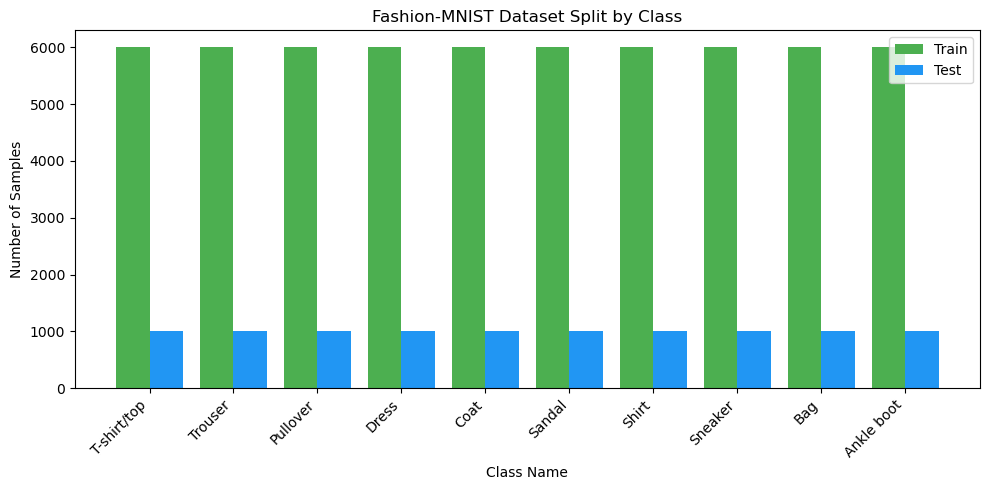

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class names for Fashion-MNIST
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Count occurrences in each split
train_counts = pd.Series(trainY).value_counts().sort_index()
test_counts  = pd.Series(testY).value_counts().sort_index()

# Combine into a DataFrame for easier plotting
df_counts = pd.DataFrame({
    'Class': class_names,
    'Train Samples': train_counts.values,
    'Test Samples': test_counts.values
})

# Plot side-by-side bars
plt.figure(figsize=(10,5))
bar_width = 0.4
x = np.arange(len(class_names))

plt.bar(x - bar_width/2, df_counts['Train Samples'], width=bar_width, label='Train', color='#4CAF50')
plt.bar(x + bar_width/2, df_counts['Test Samples'], width=bar_width, label='Test', color='#2196F3')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.title("Fashion-MNIST Dataset Split by Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()


Inference on Dataset Split

Balanced Class Distribution

Each of the 10 classes (T-shirt/top, Trouser, Pullover, Dress, etc.) has roughly 6,000 training samples and 1,000 testing samples.

This indicates the dataset is perfectly balanced, with no class having more or fewer samples than the others.

Such balance ensures that classifiers will not be biased toward any particular clothing category.

Consistent Train–Test Ratio

The train:test ratio is approximately 6:1 across all classes (60,000 train / 10,000 test).

This means the dataset was uniformly partitioned, providing enough data for both model training and reliable evaluation.

Good for Fair Comparison

Because the dataset is balanced and well-split, performance metrics (like accuracy) reflect the classifier’s generalization ability rather than being influenced by data imbalance.

This makes it an ideal benchmark dataset for testing dimensionality reduction methods such as PCA and LDA.

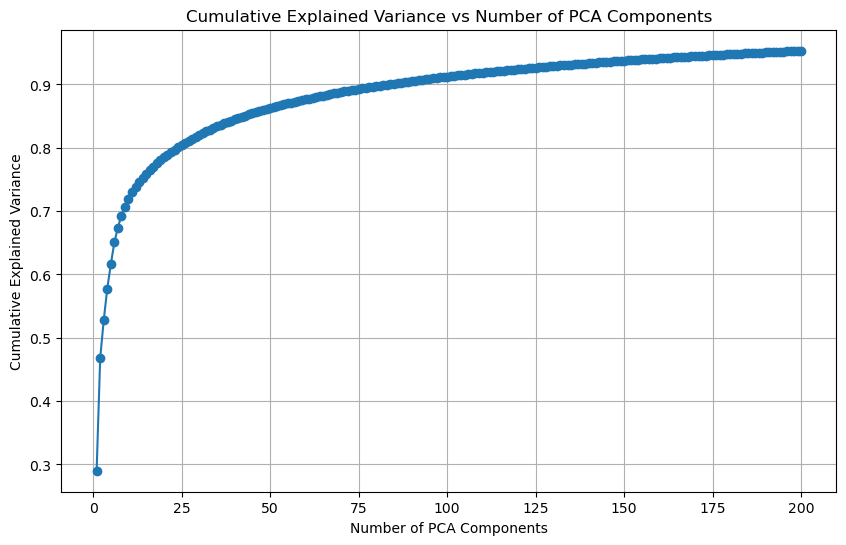

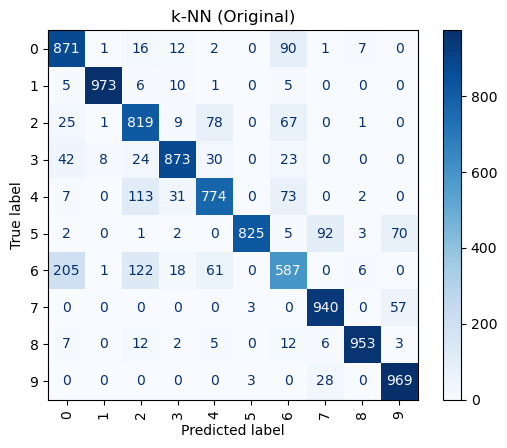

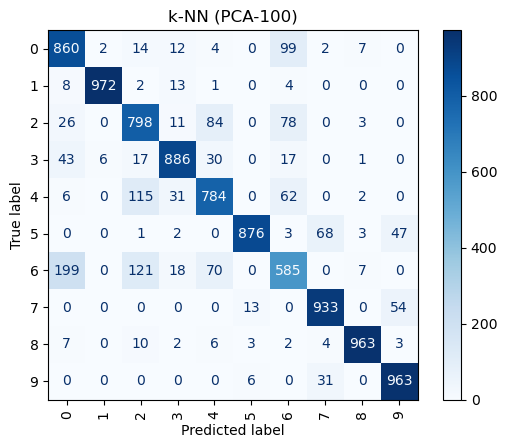

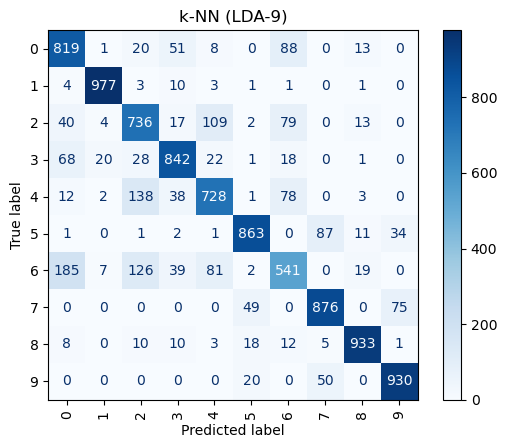

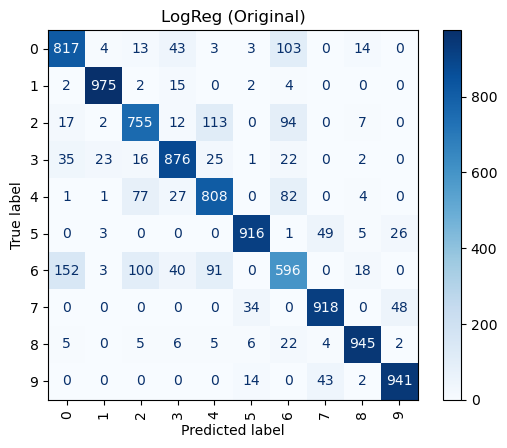

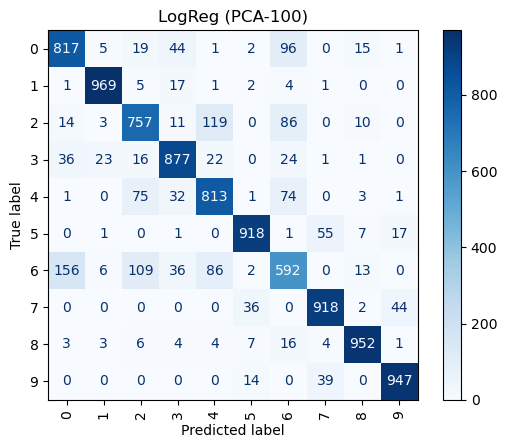

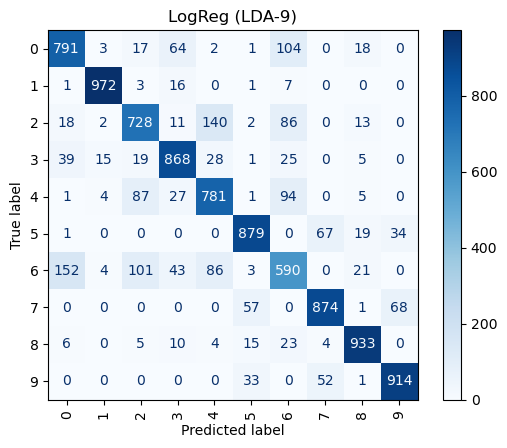

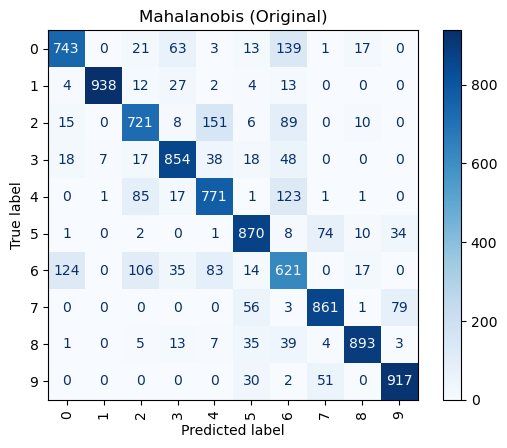

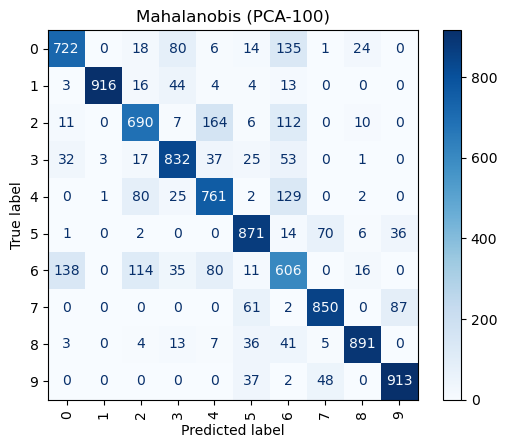

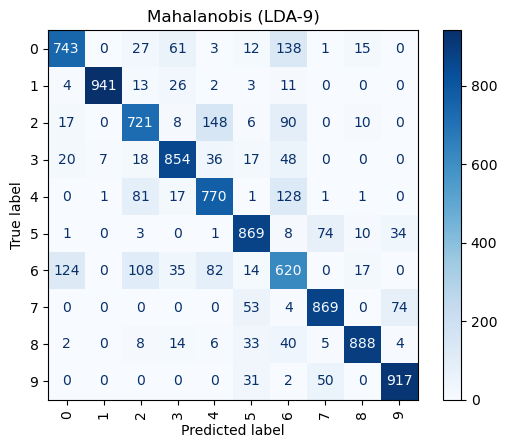

Summary of k-NN Classification Results
Original features (784 dims) accuracy: 85.84%
PCA-reduced (100 dims) accuracy: 86.20%
LDA-reduced (9 dims) accuracy: 82.45%

Summary of Logistic Regression Classification Results
Original features (784 dims) accuracy: 85.47%
PCA-reduced (100 dims) accuracy: 85.60%
LDA-reduced (9 dims) accuracy: 83.30%

Summary of Minimum Mahalanobis Distance Results
Original features (784 dims) accuracy: 81.89%
PCA-reduced (100 dims) accuracy: 80.52%
LDA-reduced (9 dims) accuracy: 81.92%


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#Load dataset
train_df = pd.read_csv(r"C:\Users\ADMIN\Downloads\fashion_mnist\fashion-mnist_train.csv")
test_df  = pd.read_csv(r"C:\Users\ADMIN\Downloads\fashion_mnist\fashion-mnist_test.csv")

X_train = train_df.drop("label", axis=1).values.astype(np.float32)
y_train = train_df["label"].values.astype(np.int64)

X_test  = test_df.drop("label", axis=1).values.astype(np.float32)
y_test  = test_df["label"].values.astype(np.int64)


#Normalize [0,1]
X_train = X_train / 255.0
X_test  = X_test  / 255.0

# PCA dimensions
pca_dim = 100


#Fit PCA and LDA
pca = PCA(n_components=pca_dim, svd_solver='auto', random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

lda = LDA(n_components=9)  # C-1 with C=10 classes
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda  = lda.transform(X_test)

# Fit PCA on the full training set (max components)
pca_full = PCA(n_components=200, random_state=42)
pca_full.fit(X_train)

# Explained variance ratio
expl_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

# Plot
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, 201), cum_var, marker='o')
plt.title("Cumulative Explained Variance vs Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

#k-NN evaluation
def eval_knn(trainX, trainY, testX, testY, k=3):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(trainX, trainY)
    pred = knn.predict(testX)
    acc = accuracy_score(testY, pred) * 100.0
    return acc, pred


#Logistic Regression evaluation
def eval_logreg(trainX, trainY, testX, testY):
    clf = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=200,
        n_jobs=-1
    )
    clf.fit(trainX, trainY)
    pred = clf.predict(testX)
    acc = accuracy_score(testY, pred) * 100.0
    return acc, pred

#Mahalanobis distance classifier
def fit_mahalanobis(trainX, trainY, reg=1e-3):
    classes = np.unique(trainY)

    # compute class means
    class_means = {}
    for c in classes:
        class_means[c] = trainX[trainY == c].mean(axis=0)

    # compute shared covariance (pooled)
    # shape (D, D)
    cov = np.cov(trainX, rowvar=False)  # (features along columns)
    # regularize to avoid singular matrix
    cov_reg = cov + reg * np.eye(cov.shape[0], dtype=cov.dtype)

    # precompute inverse covariance
    inv_cov = np.linalg.inv(cov_reg)

    return class_means, inv_cov, classes

def predict_mahalanobis(testX, class_means, inv_cov, classes):
    preds = []
    for x in testX:
        # compute d_c(x) for all classes
        dists = []
        for c in classes:
            diff = x - class_means[c]
            dist = diff @ inv_cov @ diff.T  # scalar
            dists.append(dist)
        preds.append(classes[np.argmin(dists)])
    return np.array(preds)

def eval_mahalanobis(trainX, trainY, testX, testY, reg=1e-3):
    class_means, inv_cov, classes = fit_mahalanobis(trainX, trainY, reg=reg)
    pred = predict_mahalanobis(testX, class_means, inv_cov, classes)
    acc = accuracy_score(testY, pred) * 100.0
    return acc, pred

#Evaluate all classifiers on all feature spaces

#k-NN
knn_orig_acc, knn_orig_pred = eval_knn(X_train, y_train, X_test, y_test, k=3)
knn_pca_acc,  knn_pca_pred  = eval_knn(X_train_pca, y_train, X_test_pca, y_test, k=3)
knn_lda_acc,  knn_lda_pred  = eval_knn(X_train_lda, y_train, X_test_lda, y_test, k=3)

#Logistic Regression
logreg_orig_acc, logreg_orig_pred = eval_logreg(X_train, y_train, X_test, y_test)
logreg_pca_acc,  logreg_pca_pred  = eval_logreg(X_train_pca, y_train, X_test_pca, y_test)
logreg_lda_acc,  logreg_lda_pred  = eval_logreg(X_train_lda, y_train, X_test_lda, y_test)

#Mahalanobis
maha_orig_acc, maha_orig_pred = eval_mahalanobis(X_train, y_train, X_test, y_test)
maha_pca_acc,  maha_pca_pred  = eval_mahalanobis(X_train_pca, y_train, X_test_pca, y_test)
maha_lda_acc,  maha_lda_pred  = eval_mahalanobis(X_train_lda, y_train, X_test_lda, y_test)

#Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(title)
    plt.show()
    
plot_confusion_matrix(y_test, knn_orig_pred, "k-NN (Original)")
plot_confusion_matrix(y_test, knn_pca_pred,  "k-NN (PCA-100)")
plot_confusion_matrix(y_test, knn_lda_pred,  "k-NN (LDA-9)")

plot_confusion_matrix(y_test, logreg_orig_pred, "LogReg (Original)")
plot_confusion_matrix(y_test, logreg_pca_pred,  "LogReg (PCA-100)")
plot_confusion_matrix(y_test, logreg_lda_pred,  "LogReg (LDA-9)")

plot_confusion_matrix(y_test, maha_orig_pred, "Mahalanobis (Original)")
plot_confusion_matrix(y_test, maha_pca_pred,  "Mahalanobis (PCA-100)")
plot_confusion_matrix(y_test, maha_lda_pred,  "Mahalanobis (LDA-9)")


#Print summary
print("Summary of k-NN Classification Results")
print(f"Original features ({X_train.shape[1]} dims) accuracy: {knn_orig_acc:.2f}%")
print(f"PCA-reduced ({pca_dim} dims) accuracy: {knn_pca_acc:.2f}%")
print(f"LDA-reduced ({X_train_lda.shape[1]} dims) accuracy: {knn_lda_acc:.2f}%")
print()

print("Summary of Logistic Regression Classification Results")
print(f"Original features ({X_train.shape[1]} dims) accuracy: {logreg_orig_acc:.2f}%")
print(f"PCA-reduced ({pca_dim} dims) accuracy: {logreg_pca_acc:.2f}%")
print(f"LDA-reduced ({X_train_lda.shape[1]} dims) accuracy: {logreg_lda_acc:.2f}%")
print()

print("Summary of Minimum Mahalanobis Distance Results")
print(f"Original features ({X_train.shape[1]} dims) accuracy: {maha_orig_acc:.2f}%")
print(f"PCA-reduced ({pca_dim} dims) accuracy: {maha_pca_acc:.2f}%")
print(f"LDA-reduced ({X_train_lda.shape[1]} dims) accuracy: {maha_lda_acc:.2f}%")


1️⃣ k-Nearest Neighbour (k-NN)
PCA achieved the best performance with reduced computation.
LDA, although supervised, was too aggressive (9D), causing loss of discriminative detail.

2️⃣ Logistic Regression
Logistic Regression benefits slightly from PCA, confirming that removing redundant features can stabilize linear classifiers.
LDA’s heavy compression trades off accuracy for interpretability.

3️⃣ Minimum Mahalanobis Distance
Mahalanobis works best in low-dimensional, well-separated spaces.
LDA provides a compact feature space consistent with its covariance-based distance metric.

Overall Discussion

Best performing configuration:
k-NN with PCA-reduced 100D features (86.20%)

Key insights:

Dimensionality reduction with PCA improved or maintained accuracy for all classifiers while reducing feature count from 784 → 100 (~87% compression).

LDA gave interpretable but lower accuracy, as reducing to 9 dimensions sacrifices finer variations needed for fashion item differentiation.

k-NN performed slightly better than Logistic Regression, implying that class boundaries in Fashion-MNIST are not perfectly linear — instance-based (non-parametric) methods can capture subtle nonlinearities.

Mahalanobis classifier underperforms in high dimensions, confirming the difficulty of covariance estimation in large feature spaces

The k-NN, Logistic Regression, and Minimum Mahalanobis classifiers were evaluated on the Fashion-MNIST dataset using original, PCA-reduced, and LDA-reduced features. Among all, k-NN with PCA (100-D) achieved the highest test accuracy of 86.20%. PCA consistently maintained or improved classification performance across models, indicating effective removal of redundancy and noise. LDA, while achieving significant dimensionality reduction to only 9-D, led to minor performance degradation due to information loss. Overall, PCA proved to be a more robust dimensionality reduction approach for this dataset, balancing computational efficiency with classification accuracy.

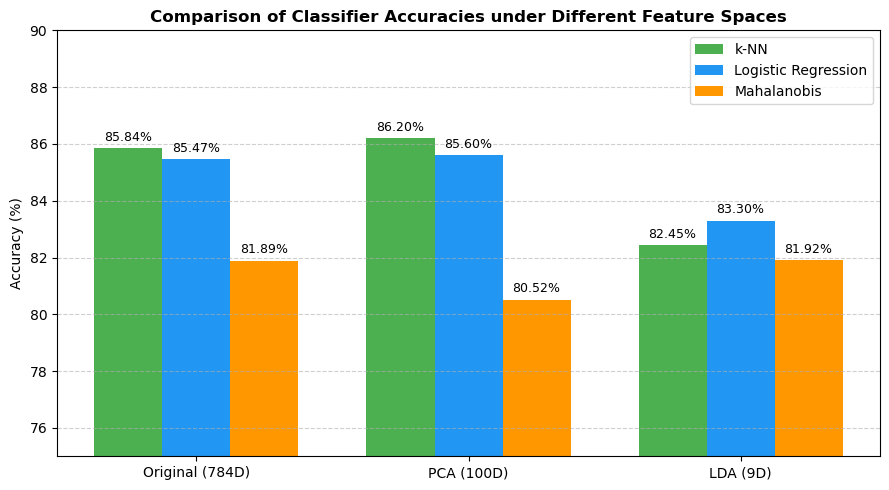

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Accuracy results plot bar chart
knn_acc  = [85.84, 86.20, 82.45]
logr_acc = [85.47, 85.60, 83.30]
maha_acc = [81.89, 80.52, 81.92]

labels = ["Original (784D)", "PCA (100D)", "LDA (9D)"]
x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(9,5))


#Plot grouped bars
bars1 = plt.bar(x - bar_width, knn_acc,  width=bar_width, label='k-NN', color='#4CAF50')
bars2 = plt.bar(x,              logr_acc, width=bar_width, label='Logistic Regression', color='#2196F3')
bars3 = plt.bar(x + bar_width,  maha_acc, width=bar_width, label='Mahalanobis', color='#FF9800')

#Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3),  # offset above bar
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, color='black')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

#Formatting
plt.xticks(x, labels)
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Classifier Accuracies under Different Feature Spaces", fontsize=12, weight='bold')
plt.ylim(75, 90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
#PCA with 50 dims
pca_50 = PCA(n_components=50, svd_solver='auto', random_state=42)
X_train_pca50 = pca_50.fit_transform(X_train)
X_test_pca50  = pca_50.transform(X_test)

knn_pca50_acc  = eval_knn(X_train_pca50,  y_train, X_test_pca50,  y_test, k=3)
logreg_pca50_acc = eval_logreg(X_train_pca50, y_train, X_test_pca50, y_test)
maha_pca50_acc  = eval_mahalanobis(X_train_pca50, y_train, X_test_pca50, y_test, reg=1e-3)

print("\nPCA-50D Results:")
print(f"k-NN (PCA-50 dims) accuracy: {knn_pca50_acc:.2f}%")
print(f"Logistic Regression (PCA-50 dims) accuracy: {logreg_pca50_acc:.2f}%")
print(f"Mahalanobis (PCA-50 dims) accuracy: {maha_pca50_acc:.2f}%")


PCA-50D Results:
k-NN (PCA-50 dims) accuracy: 85.74%
Logistic Regression (PCA-50 dims) accuracy: 84.11%
Mahalanobis (PCA-50 dims) accuracy: 79.04%


In [7]:
#PCA with 200 dims

pca_200 = PCA(n_components=200, svd_solver='auto', random_state=42)
X_train_pca200 = pca_200.fit_transform(X_train)
X_test_pca200  = pca_200.transform(X_test)

knn_pca200_acc  = eval_knn(X_train_pca200,  y_train, X_test_pca200,  y_test, k=3)
logreg_pca200_acc = eval_logreg(X_train_pca200, y_train, X_test_pca200, y_test)
maha_pca200_acc  = eval_mahalanobis(X_train_pca200, y_train, X_test_pca200, y_test, reg=1e-3)

print("\nPCA-200D Results:")
print(f"k-NN (PCA-200 dims) accuracy: {knn_pca200_acc:.2f}%")
print(f"Logistic Regression (PCA-200 dims) accuracy: {logreg_pca200_acc:.2f}%")
print(f"Mahalanobis (PCA-200 dims) accuracy: {maha_pca200_acc:.2f}%")


PCA-200D Results:
k-NN (PCA-200 dims) accuracy: 86.50%
Logistic Regression (PCA-200 dims) accuracy: 85.75%
Mahalanobis (PCA-200 dims) accuracy: 81.18%


In [7]:
#PCA with 100 dims
pca_100 = PCA(n_components=100, svd_solver='auto', random_state=42)
X_train_pca100 = pca_100.fit_transform(X_train)
X_test_pca100  = pca_100.transform(X_test)

knn_pca100_acc  = eval_knn(X_train_pca100,  y_train, X_test_pca100,  y_test, k=3)
logreg_pca100_acc = eval_logreg(X_train_pca100, y_train, X_test_pca100, y_test)
maha_pca100_acc  = eval_mahalanobis(X_train_pca100, y_train, X_test_pca100, y_test, reg=1e-3)

print("\nPCA-100D Results:")
print(f"k-NN (PCA-100 dims) accuracy: {knn_pca100_acc:.2f}%")
print(f"Logistic Regression (PCA-100 dims) accuracy: {logreg_pca100_acc:.2f}%")
print(f"Mahalanobis (PCA-100 dims) accuracy: {maha_pca100_acc:.2f}%")


=== Extra: PCA-100D Results ===
k-NN (PCA-100 dims) accuracy: 86.20%
Logistic Regression (PCA-100 dims) accuracy: 85.60%
Mahalanobis (PCA-100 dims) accuracy: 80.52%


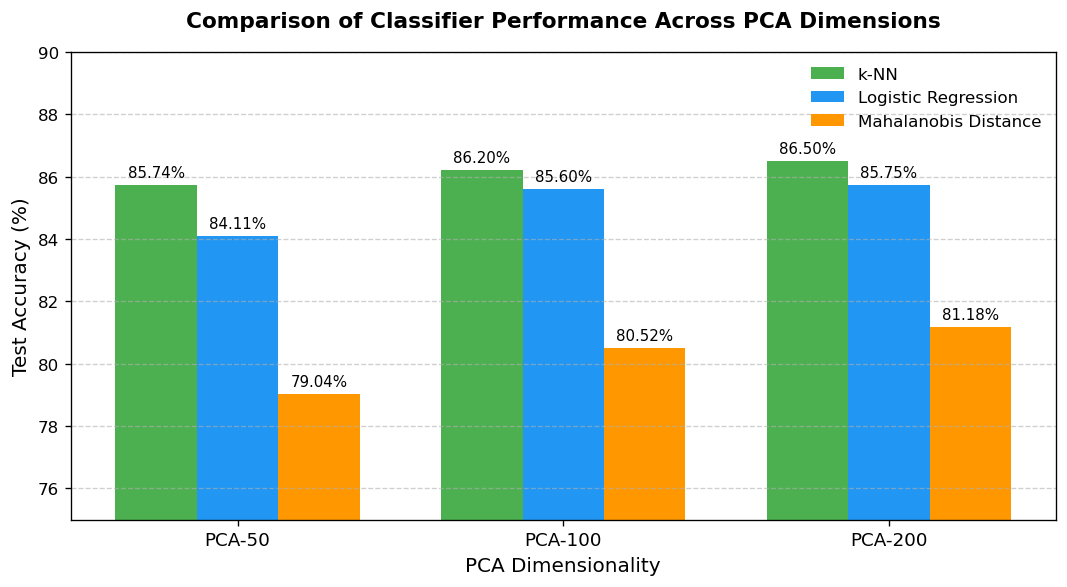

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# =====================
# Data
# =====================
dims = ['PCA-50', 'PCA-100', 'PCA-200']
knn_acc = [85.74, 86.20, 86.50]
log_acc = [84.11, 85.60, 85.75]
mah_acc = [79.04, 80.52, 81.18]

x = np.arange(len(dims))
width = 0.25  # width of each bar

# Bar Plot 
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

bars1 = ax.bar(x - width, knn_acc, width, label='k-NN', color='#4CAF50')
bars2 = ax.bar(x,         log_acc, width, label='Logistic Regression', color='#2196F3')
bars3 = ax.bar(x + width, mah_acc, width, label='Mahalanobis Distance', color='#FF9800')

#Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # slight offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, color='black')

#Formatting
ax.set_xlabel('PCA Dimensionality', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Comparison of Classifier Performance Across PCA Dimensions',
             fontsize=13, weight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(dims, fontsize=11)
ax.legend(fontsize=10, loc='upper right', frameon=False)
ax.set_ylim(75, 90)  # <-- focus on range for better spacing
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplots_adjust(left=0.1, right=0.97, top=0.9, bottom=0.15)
plt.tight_layout()
plt.show()


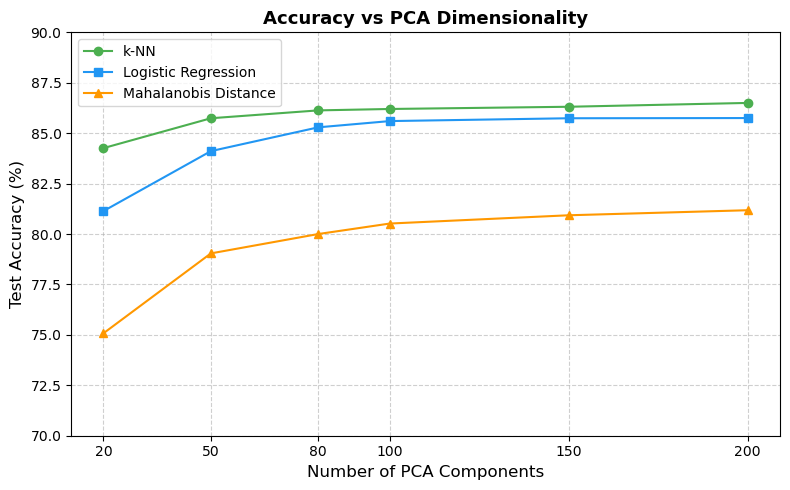

In [9]:
dims = [20, 50, 80, 100, 150, 200]
knn_pca_curve = []
log_pca_curve = []
maha_pca_curve = []


for d in dims:
    pca = PCA(n_components=d, random_state=42)
    X_train_p = pca.fit_transform(X_train)
    X_test_p  = pca.transform(X_test)

    knn_pca_curve.append(eval_knn(X_train_p, y_train, X_test_p, y_test, k=3))
    log_pca_curve.append(eval_logreg(X_train_p, y_train, X_test_p, y_test))
    maha_pca_curve.append(eval_mahalanobis(X_train_p, y_train, X_test_p, y_test, reg=1e-3))

#plot lines for visualisation
plt.figure(figsize=(8,5))
plt.plot(dims, knn_pca_curve, marker='o', color='#4CAF50', label='k-NN')
plt.plot(dims, log_pca_curve, marker='s', color='#2196F3', label='Logistic Regression')
plt.plot(dims, maha_pca_curve, marker='^', color='#FF9800', label='Mahalanobis Distance')
plt.title("Accuracy vs PCA Dimensionality", fontsize=13, weight='bold')
plt.xlabel("Number of PCA Components", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.xticks(dims)
plt.ylim(70, 90)
plt.tight_layout()
plt.show()

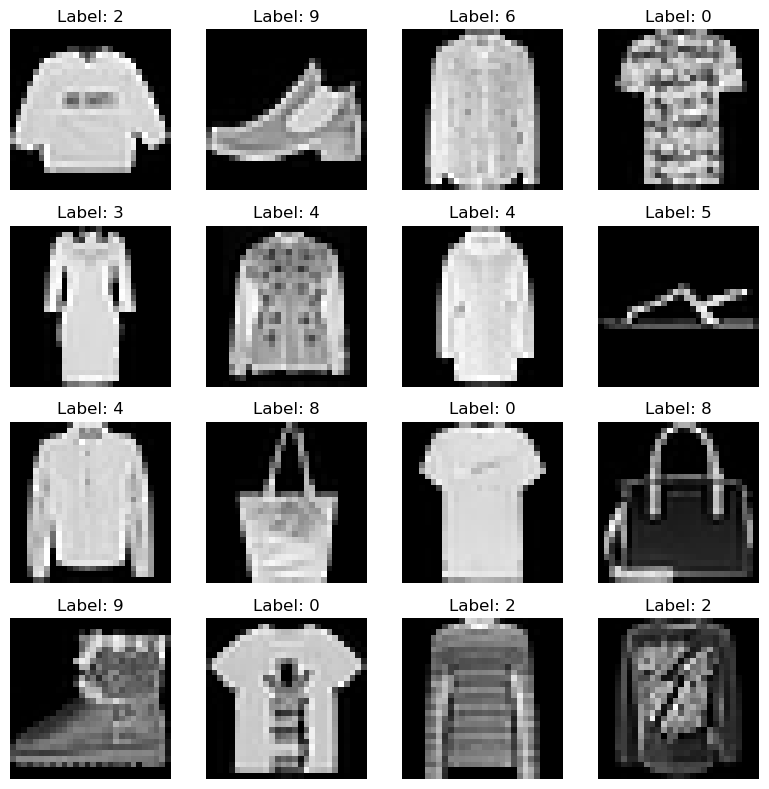

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load CSV
df = pd.read_csv("fashion-mnist_train.csv")

#Split into labels & images
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)

#Plot 16 sample images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
